# Təsadüfi Meşə (Random Forest) ilə Kredit Satışı Proqnozlaşdırılması

## Giriş / Introduction

Bu dəftərdə biz **Təsadüfi Meşə** (Random Forest) metodundan istifadə edərək kredit satışını proqnozlaşdıracağıq.

### Təsadüfi Meşə nədir?

Təsadüfi Meşə bir **ensemble** (birlikdə) maşın öyrənməsi metodudur. Əsas ideyası:

**Çoxlu sadə qərar ağaclarını birləşdirərək güclü model yaratmaq!**

### Necə işləyir?

Təsəvvür edin:
- 100 müxtəlif ekspert var
- Hər biri fərqli məlumatlardan istifadə edərək öz proqnozunu verir
- Sonra bütün proqnozların **ortalamasını** götürürük

Bu, bir ekspertin fikrindən daha etibarlıdır! 🌲🌲🌲 → 🌳 **Meşə**

### Əsas Komponentlər:

1. **Qərar Ağacı (Decision Tree)**: Sadə, amma güclü model
2. **Bagging**: Hər ağac fərqli məlumat nümunəsindən öyrənir
3. **Təsadüfi Xüsusiyyət Seçimi**: Hər ağac fərqli xüsusiyyətlərə baxır
4. **Səsvermə/Ortalama**: Bütün ağacların nəticələrini birləşdirir

### Niyə bu yanaşma?

- ✅ **Güclü**: Mürəkkəb qeyri-xətti əlaqələri tutur
- ✅ **Davamlı**: Outlier-lərə (kənar dəyərlərə) həssas deyil
- ✅ **Overfitting-ə qarşı**: Çoxlu ağac ortalaması daha stabil nəticə verir
- ✅ **Xüsusiyyət Əhəmiyyəti**: Hansı xüsusiyyətlərin vacib olduğunu göstərir
- ✅ **Az parametr tənzimləməsi**: "Out of the box" yaxşı işləyir

### Bu dəftərdə nə edəcəyik?

Addım-addım:
1. Məlumatları yükləyib başa düşəcəyik
2. Təsadüfi Meşə modelini quracağıq
3. Xüsusiyyət əhəmiyyətini öyrənəcəyik
4. Modelin performansını qiymətləndirəcəyik
5. Fərdi ağacları və onların fərqliliyini təhlil edəcəyik

Gəlin başlayaq! 🚀

## Addım 1: Kitabxanaların Yüklənməsi

İlk olaraq bizə lazım olan alətləri yükləyirik.

In [1]:
# Əsas məlumat emal kitabxanaları
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Təsadüfi Meşə üçün
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance

# Qrafik parametrləri
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'

print("✅ Bütün alətlər uğurla yükləndi!")

✅ Bütün alətlər uğurla yükləndi!


## Addım 2: Məlumatların Yüklənməsi və Hazırlanması

İndi kredit satış məlumatlarımızı yükləyək.

In [2]:
# Məlumatları oxuyaq
df = pd.read_csv('data/ml_ready_data.csv')

# Bizə lazım olan sütunlar
required_cols = ['Rüblər', 'Year', 'Quarter', 'Nağd_pul_kredit_satışı']
df_work = df[required_cols].copy()

# Zaman indeksi əlavə edək
df_work['Time_Index'] = range(len(df_work))

# Hədəf dəyişən
target_col = 'Nağd_pul_kredit_satışı'

print("=" * 80)
print("MƏLUMAT HAQQINDA")
print("=" * 80)
print(f"\n📅 Dövr: {df_work['Rüblər'].iloc[0]} → {df_work['Rüblər'].iloc[-1]}")
print(f"📊 Müşahidə sayı: {len(df_work)} rüb")
print(f"📆 İllər: {df_work['Year'].min()} - {df_work['Year'].max()}")
print(f"\n🎯 Hədəf: {target_col}")
print(f"   • Ortalama: {df_work[target_col].mean():,.2f}")
print(f"   • Minimum: {df_work[target_col].min():,.2f}")
print(f"   • Maksimum: {df_work[target_col].max():,.2f}")
print(f"   • Standart sapma: {df_work[target_col].std():,.2f}")
print("\n" + "=" * 80)

# Xüsusiyyətlər və hədəf
feature_cols = ['Time_Index', 'Quarter']
X = df_work[feature_cols].copy()
y = df_work[target_col].copy()

# 80/20 bölgü
split_point = int(len(X) * 0.8)
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print(f"\n✂️  Məlumat Bölgüsü:")
print(f"   • Təlim: {len(X_train)} müşahidə ({len(X_train)/len(X)*100:.0f}%)")
print(f"   • Test:  {len(X_test)} müşahidə ({len(X_test)/len(X)*100:.0f}%)")
print(f"   • Xüsusiyyətlər: {', '.join(feature_cols)}")

print("\n📋 İlk 3 sətir:")
df_work[['Rüblər', 'Time_Index', 'Quarter', target_col]].head(3)

MƏLUMAT HAQQINDA

📅 Dövr: 2020 I → 2025 II
📊 Müşahidə sayı: 22 rüb
📆 İllər: 2020 - 2025

🎯 Hədəf: Nağd_pul_kredit_satışı
   • Ortalama: 80,612.82
   • Minimum: 15,709.38
   • Maksimum: 126,285.41
   • Standart sapma: 32,218.08


✂️  Məlumat Bölgüsü:
   • Təlim: 17 müşahidə (77%)
   • Test:  5 müşahidə (23%)
   • Xüsusiyyətlər: Time_Index, Quarter

📋 İlk 3 sətir:


,Rüblər,Time_Index,Quarter,Nağd_pul_kredit_satışı
0,2020 I,0,1,46642.84149
1,2020 II,1,2,15709.38447
2,2020 III,2,3,51257.54777


## Addım 3: Sadə Qərar Ağacı - Başlanğıc Nöqtəsi

### Qərar Ağacı nədir?

Qərar ağacı "bəli/xeyr" sualları verərək qərarlar qəbul edən modeldir:

```
Time_Index < 10?
    ├─ Bəli → Kredit satışı aşağıdır
    └─ Xeyr → Quarter < 3?
              ├─ Bəli → Orta səviyyə
              └─ Xeyr → Yüksək səviyyə
```

### Niyə sadə ağac göstəririk?

Təsadüfi Meşə yüzlərlə belə ağacın birləşməsidir. Əvvəlcə bir ağacı başa düşmək vacibdir.

In [3]:
print("🌲 SADƏ QƏRAR AĞACI QURULUR...")
print("=" * 80)

# Sadə, kiçik ağac (max_depth=3 - yalnız 3 səviyyə dərinlik)
simple_tree = DecisionTreeRegressor(max_depth=3, random_state=42)
simple_tree.fit(X_train, y_train)

# Proqnozlar
tree_pred = simple_tree.predict(X_test)
tree_r2 = r2_score(y_test, tree_pred)
tree_mae = mean_absolute_error(y_test, tree_pred)

print(f"\n📊 Sadə Qərar Ağacı Performansı:")
print(f"   • Test R²: {tree_r2:.4f}")
print(f"   • Test MAE: {tree_mae:,.2f}")
print(f"   • Ağacın dərinliyi: {simple_tree.get_depth()}")
print(f"   • Yarpaq sayı: {simple_tree.get_n_leaves()}")

print("\n💡 Bu sadə bir ağacdır. İndi çoxlu ağacı birləşdirəcəyik!")

🌲 SADƏ QƏRAR AĞACI QURULUR...

📊 Sadə Qərar Ağacı Performansı:
   • Test R²: -0.0965
   • Test MAE: 24,092.40
   • Ağacın dərinliyi: 3
   • Yarpaq sayı: 8

💡 Bu sadə bir ağacdır. İndi çoxlu ağacı birləşdirəcəyik!


## Addım 4: Təsadüfi Meşə Modelinin Qurulması

### Model parametrləri:

1. **n_estimators**: Neçə ağac quracağıq? (daha çox = daha yaxşı, amma daha yavaş)
2. **max_depth**: Hər ağacın maksimum dərinliyi (kiçik = sadə ağaclar, overfitting-ə qarşı)
3. **min_samples_split**: Bir node-u bölmək üçün minimum nümunə sayı
4. **random_state**: Təkrarlanabilirlik üçün (eyni nəticələr)

### Bizim seçimimiz:

- **n_estimators=100**: 100 ağac - kifayət qədər çox, amma sürətli
- **max_depth=5**: Orta dərinlik - overfitting-dən qorunmaq üçün
- **min_samples_split=3**: Az nümunə olduğu üçün kiçik dəyər
- **random_state=42**: Nəticələr hər dəfə eyni olsun

In [4]:
print("🌳 TƏSADÜFİ MEŞƏ MODELİ QURULUR...")
print("=" * 80)

# Təsadüfi Meşə modeli
rf_model = RandomForestRegressor(
    n_estimators=100,        # 100 ağac
    max_depth=5,             # Maksimum 5 səviyyə dərinlik
    min_samples_split=3,     # Bölmək üçün minimum 3 nümunə
    random_state=42,         # Təkrarlanabilirlik
    n_jobs=-1                # Bütün prosessorları işlət (sürətli)
)

print("\n⏳ Model 100 ağacdan öyrənir...")
rf_model.fit(X_train, y_train)
print("✅ Model uğurla öyrənildi!\n")

print("📋 MODEL KONFİQURASİYASI")
print("-" * 80)
print(f"Model tipi:              Təsadüfi Meşə (Random Forest)")
print(f"Ağac sayı:               {rf_model.n_estimators}")
print(f"Maksimum dərinlik:       {rf_model.max_depth}")
print(f"Min. bölmə nümunəsi:     {rf_model.min_samples_split}")
print(f"Xüsusiyyətlər:           {', '.join(feature_cols)}")
print(f"Təlim nümunələri:        {len(X_train)}")

print("\n💡 100 MÜXTƏLİF AĞAC:")
print("   Hər ağac təlim məlumatlarının fərqli bir hissəsindən öyrənib.")
print("   Hər ağac fərqli qərarlar qəbul edir.")
print("   Final proqnoz = Bütün ağacların ortalama proqnozu")
print("\n" + "=" * 80)

🌳 TƏSADÜFİ MEŞƏ MODELİ QURULUR...

⏳ Model 100 ağacdan öyrənir...
✅ Model uğurla öyrənildi!

📋 MODEL KONFİQURASİYASI
--------------------------------------------------------------------------------
Model tipi:              Təsadüfi Meşə (Random Forest)
Ağac sayı:               100
Maksimum dərinlik:       5
Min. bölmə nümunəsi:     3
Xüsusiyyətlər:           Time_Index, Quarter
Təlim nümunələri:        17

💡 100 MÜXTƏLİF AĞAC:
   Hər ağac təlim məlumatlarının fərqli bir hissəsindən öyrənib.
   Hər ağac fərqli qərarlar qəbul edir.
   Final proqnoz = Bütün ağacların ortalama proqnozu



## Addım 5: Xüsusiyyət Əhəmiyyəti (Feature Importance)

### Xüsusiyyət əhəmiyyəti nədir?

Hər xüsusiyyətin modelin qərarlarında nə qədər **təsirli** olduğunu göstərir.

### Necə hesablanır?

Təsadüfi Meşədə hər ağac hər xüsusiyyətdən neçə dəfə və nə qədər effektiv istifadə etdiyini ölçürük.

### Niyə vacibdir?

- Hansı amillərin kredit satışına daha çox təsir etdiyini başa düşürük
- Vacib olmayan xüsusiyyətləri çıxara bilərik
- Biznes qərarları üçün faydalıdır

**Qeyd:** Cəm 100% (1.0) olmalıdır

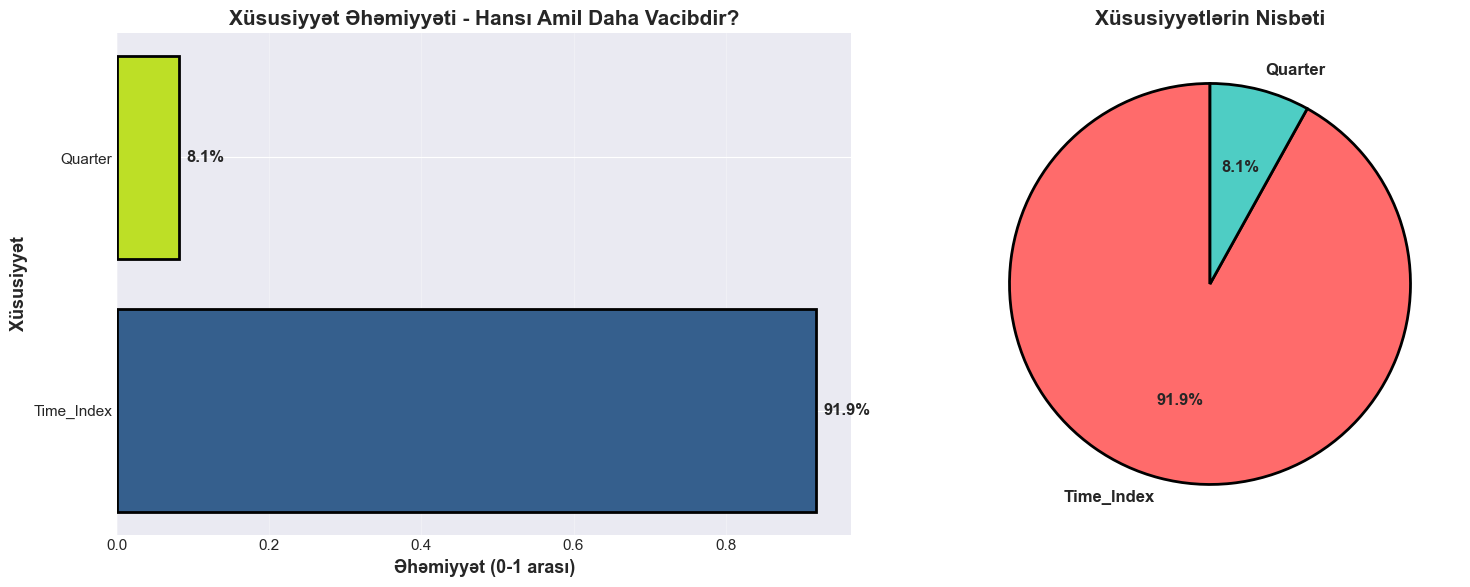


📊 XÜSUSİYYƏT ƏHƏMİYYƏTİ CƏDVƏLİ
Xüsusiyyət  Əhəmiyyət  Əhəmiyyət (%)
Time_Index   0.919385      91.938453
   Quarter   0.080615       8.061547


💡 TƏFSİR:
   • Ən vacib xüsusiyyət: Time_Index (91.9%)
   • Bu o deməkdir ki, modelin qərarlarının 91.9%-i
     Time_Index xüsusiyyətindən asılıdır.

⚠️  DİQQƏT: Bir xüsusiyyət çox dominant! Model çox sadə ola bilər.


In [5]:
# Xüsusiyyət əhəmiyyəti
feature_importance = rf_model.feature_importances_

# DataFrame yaradaq
importance_df = pd.DataFrame({
    'Xüsusiyyət': feature_cols,
    'Əhəmiyyət': feature_importance,
    'Əhəmiyyət (%)': feature_importance * 100
}).sort_values('Əhəmiyyət', ascending=False)

# Vizualizasiya
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Sol: Bar chart
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
bars = ax1.barh(importance_df['Xüsusiyyət'], importance_df['Əhəmiyyət'], 
               color=colors, edgecolor='black', linewidth=2)

# Dəyərləri göstər
for i, (bar, val) in enumerate(zip(bars, importance_df['Əhəmiyyət'])):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{val*100:.1f}%', ha='left', va='center', 
            fontsize=12, fontweight='bold')

ax1.set_xlabel('Əhəmiyyət (0-1 arası)', fontsize=13, fontweight='bold')
ax1.set_ylabel('Xüsusiyyət', fontsize=13, fontweight='bold')
ax1.set_title('Xüsusiyyət Əhəmiyyəti - Hansı Amil Daha Vacibdir?', 
             fontsize=15, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Sağ: Pie chart
colors_pie = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
ax2.pie(importance_df['Əhəmiyyət'], labels=importance_df['Xüsusiyyət'],
       autopct='%1.1f%%', startangle=90, colors=colors_pie[:len(importance_df)],
       textprops={'fontsize': 12, 'fontweight': 'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 2})
ax2.set_title('Xüsusiyyətlərin Nisbəti', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 XÜSUSİYYƏT ƏHƏMİYYƏTİ CƏDVƏLİ")
print("=" * 80)
print(importance_df.to_string(index=False))
print("\n" + "=" * 80)

print("\n💡 TƏFSİR:")
top_feature = importance_df.iloc[0]
print(f"   • Ən vacib xüsusiyyət: {top_feature['Xüsusiyyət']} ({top_feature['Əhəmiyyət (%)']:.1f}%)")
print(f"   • Bu o deməkdir ki, modelin qərarlarının {top_feature['Əhəmiyyət (%)']:.1f}%-i")
print(f"     {top_feature['Xüsusiyyət']} xüsusiyyətindən asılıdır.")

if importance_df.iloc[0]['Əhəmiyyət'] > 0.7:
    print(f"\n⚠️  DİQQƏT: Bir xüsusiyyət çox dominant! Model çox sadə ola bilər.")
elif importance_df.iloc[0]['Əhəmiyyət'] < 0.4:
    print(f"\n✅ YAXŞI: Xüsusiyyətlər balanslaşdırılıb, heç biri həddindən artıq dominant deyil.")

## Addım 6: Proqnozların Hazırlanması və Qiymətləndirilməsi

### İndi model hazırdır!

100 ağacın hər biri öz proqnozunu verir, sonra ortalamasını götürürük.

### Qiymətləndirmə:
- **R²**: Modelin izah etdiyi variasiya (1-ə yaxın = yaxşı)
- **MAE**: Orta mütləq xəta (aşağı = yaxşı)
- **RMSE**: Kök orta kvadrat xəta (böyük xətaları daha çox cəzalandırır)

In [6]:
print("📊 PROQNOZLAR HAZIRLANIR...")
print("=" * 80)

# Proqnozlar
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# Metrikləri hesabla
# Təlim
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Test
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\n✅ PROQNOZLAR HAZIRLANDI!\n")

print("📈 PERFORMANS NƏTİCƏLƏRİ")
print("=" * 80)
print(f"\n{'Metrika':<25} {'Təlim':>15} {'Test':>15} {'Fərq':>15}")
print("-" * 80)
print(f"{'R² Score':<25} {train_r2:>15.4f} {test_r2:>15.4f} {train_r2-test_r2:>15.4f}")
print(f"{'MAE (manat)':<25} {train_mae:>15,.2f} {test_mae:>15,.2f} {train_mae-test_mae:>15,.2f}")
print(f"{'RMSE (manat)':<25} {train_rmse:>15,.2f} {test_rmse:>15,.2f} {train_rmse-test_rmse:>15,.2f}")
print("\n" + "=" * 80)

print("\n💡 NƏTİCƏLƏRİN TƏFSİRİ:")
print("-" * 80)

print(f"\n1️⃣  TEST R²: {test_r2:.4f}")
if test_r2 > 0.8:
    print(f"    ✅ ÇOX YAXŞI! Model məlumatların {test_r2*100:.1f}%-ni izah edir.")
elif test_r2 > 0.6:
    print(f"    ✅ YAXŞI! Model məlumatların {test_r2*100:.1f}%-ni izah edir.")
elif test_r2 > 0.4:
    print(f"    ⚠️  ORTA. Model məlumatların {test_r2*100:.1f}%-ni izah edir.")
else:
    print(f"    ❌ ZƏİF. Model məlumatların yalnız {test_r2*100:.1f}%-ni izah edir.")

print(f"\n2️⃣  TEST MAE: {test_mae:,.2f} manat")
mae_percent = (test_mae / y_test.mean()) * 100
print(f"    Proqnozlar orta hesabla {test_mae:,.0f} manat fərqlənir.")
print(f"    Bu, ortalama satışın {mae_percent:.1f}%-ni təşkil edir.")

print(f"\n3️⃣  OVERFİTTİNG YOXLANIŞI:")
overfitting_score = train_r2 - test_r2
if overfitting_score < 0.05:
    print(f"    ✅ ÇOX YAXŞI! Təlim-Test R² fərqi: {overfitting_score:.4f}")
    print(f"    Overfitting yoxdur, model yaxşı ümumiləşdirir.")
elif overfitting_score < 0.15:
    print(f"    ⚠️  QƏBUL EDİLƏBİLƏN. Təlim-Test R² fərqi: {overfitting_score:.4f}")
    print(f"    Yüngül overfitting var, amma narahat olmağa dəyməz.")
else:
    print(f"    ❌ PROBLEMLİ! Təlim-Test R² fərqi: {overfitting_score:.4f}")
    print(f"    Güclü overfitting! Model təlim məlumatlarını 'əzbərləyib'.")
    print(f"    Həll: max_depth azalt, min_samples_split artır.")

# Sadə ağacla müqayisə
print(f"\n4️⃣  SADƏ AĞACLA MÜQAYİSƏ:")
print(f"    Sadə ağac R²: {tree_r2:.4f}")
print(f"    Təsadüfi Meşə R²: {test_r2:.4f}")
improvement = ((test_r2 - tree_r2) / tree_r2) * 100 if tree_r2 > 0 else 0
if improvement > 0:
    print(f"    ✅ Təsadüfi Meşə {improvement:.1f}% daha yaxşıdır!")
else:
    print(f"    ⚠️  Təsadüfi Meşə gözləntini ödəmədi.")

📊 PROQNOZLAR HAZIRLANIR...

✅ PROQNOZLAR HAZIRLANDI!

📈 PERFORMANS NƏTİCƏLƏRİ

Metrika                             Təlim            Test            Fərq
--------------------------------------------------------------------------------
R² Score                           0.9258          0.0239          0.9019
MAE (manat)                      6,401.98       26,197.95      -19,795.97
RMSE (manat)                     7,942.56       34,164.15      -26,221.58


💡 NƏTİCƏLƏRİN TƏFSİRİ:
--------------------------------------------------------------------------------

1️⃣  TEST R²: 0.0239
    ❌ ZƏİF. Model məlumatların yalnız 2.4%-ni izah edir.

2️⃣  TEST MAE: 26,197.95 manat
    Proqnozlar orta hesabla 26,198 manat fərqlənir.
    Bu, ortalama satışın 27.5%-ni təşkil edir.

3️⃣  OVERFİTTİNG YOXLANIŞI:
    ❌ PROBLEMLİ! Təlim-Test R² fərqi: 0.9019
    Güclü overfitting! Model təlim məlumatlarını 'əzbərləyib'.
    Həll: max_depth azalt, min_samples_split artır.

4️⃣  SADƏ AĞACLA MÜQAYİSƏ:
    Sadə ağ

## Addım 7: Faktiki vs Proqnoz - Vizualizasiya

### Bu qrafik nə göstərir?

100 ağacın birlikdə nə qədər yaxşı işlədiyini görəcəyik:

- **Yaşıl**: Faktiki təlim məlumatları
- **Açıq yaşıl**: Təlim proqnozları
- **Qırmızı**: Faktiki test məlumatları
- **Çəhrayı**: Test proqnozları (modelin heç görmədiyi məlumatlar üçün!)

**İdeal:** Proqnozlar faktiki dəyərlərlə üst-üstə düşməlidir.

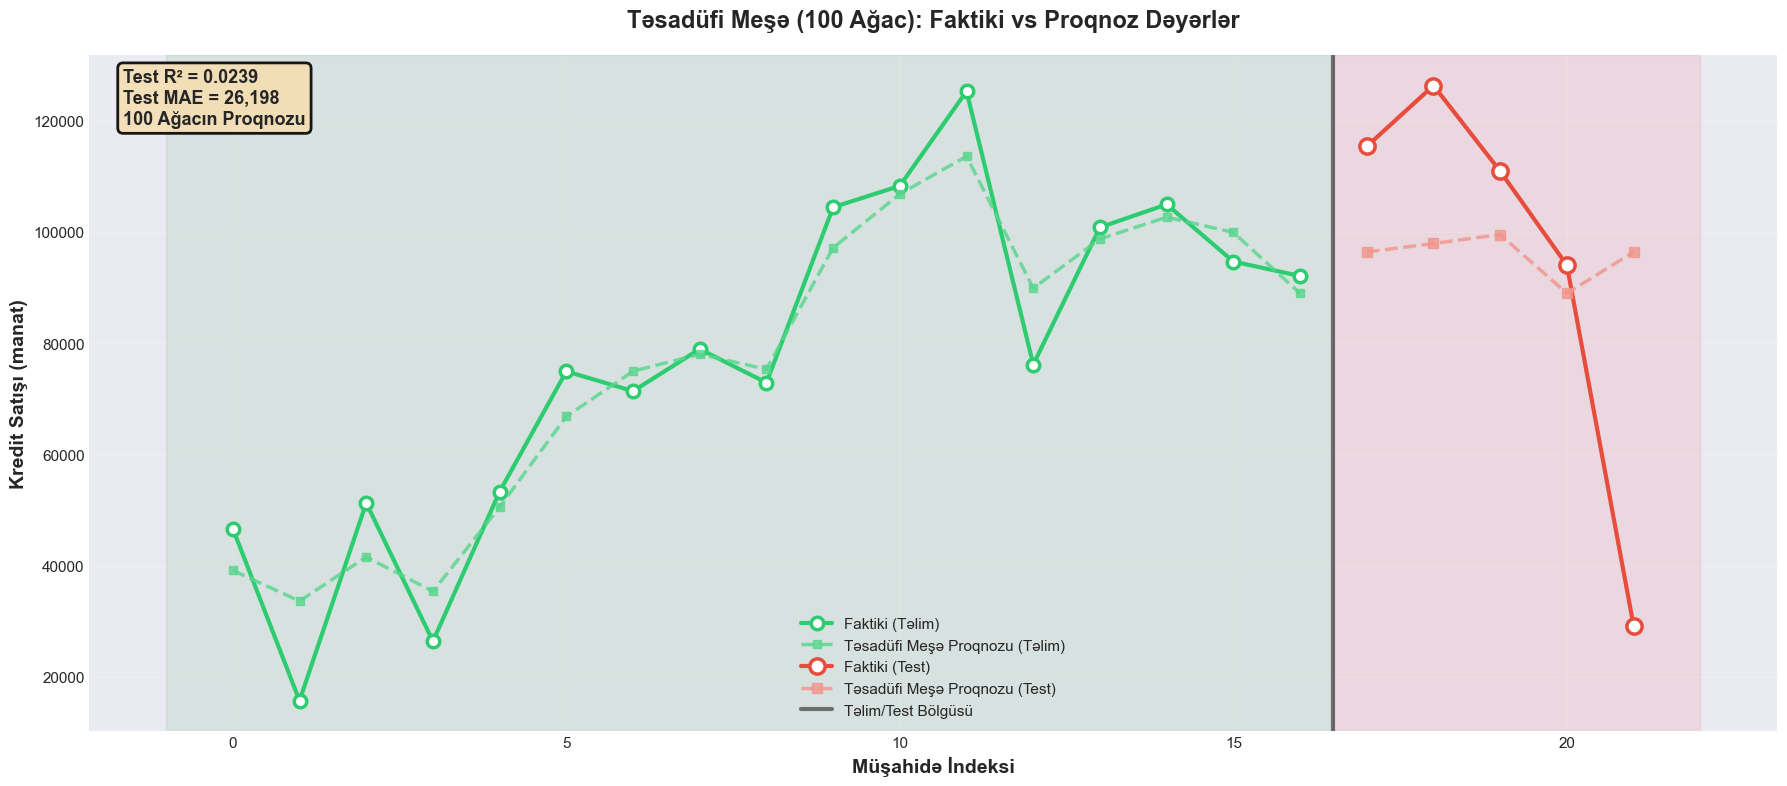


📊 VİZUAL TƏHLİL

🌲 TƏSADÜFİ MEŞƏ EFFEKTI:
   100 ağacın hər biri fərqli proqnoz verir.
   Qrafiktə gördüyünüz nəticə = Bütün proqnozların ORTALAMASI
   Bu, tək ağacdan daha sabit və etibarlı nəticə verir.

🎯 NƏTİCƏ:
   ⚠️  Proqnozlar və faktiki dəyərlər arasında fərq var.
   Səbəb ola bilər: Az məlumat, sadə xüsusiyyətlər, güclü qeyri-xətti nümunələr.


In [7]:
# Böyük vizualizasiya
fig, ax = plt.subplots(figsize=(18, 8))

# Təlim
train_indices = range(len(y_train))
ax.plot(train_indices, y_train.values, 
        marker='o', linewidth=3, markersize=9, color='#2ECC71',
        label='Faktiki (Təlim)', markerfacecolor='white', 
        markeredgewidth=2.5, markeredgecolor='#2ECC71')

ax.plot(train_indices, y_train_pred, 
        linestyle='--', linewidth=2.5, color='#58D68D', alpha=0.8,
        label='Təsadüfi Meşə Proqnozu (Təlim)', marker='s', markersize=6)

# Test
test_start = len(y_train)
test_indices = range(test_start, test_start + len(y_test))
ax.plot(test_indices, y_test.values,
        marker='o', linewidth=3, markersize=11, color='#E74C3C',
        label='Faktiki (Test)', markerfacecolor='white',
        markeredgewidth=2.5, markeredgecolor='#E74C3C')

ax.plot(test_indices, y_test_pred,
        linestyle='--', linewidth=2.5, color='#F1948A', alpha=0.8,
        label='Təsadüfi Meşə Proqnozu (Test)', marker='s', markersize=7)

# Bölgü xətti
ax.axvline(x=test_start-0.5, color='black', linestyle='-', 
          linewidth=3, alpha=0.5, label='Təlim/Test Bölgüsü')

# Bölgələr
ax.axvspan(-1, test_start-0.5, alpha=0.08, color='green')
ax.axvspan(test_start-0.5, len(y), alpha=0.08, color='red')

# Statistika qutusu
stats_text = f'Test R² = {test_r2:.4f}\nTest MAE = {test_mae:,.0f}\n100 Ağacın Proqnozu'
ax.text(0.02, 0.98, stats_text, 
       transform=ax.transAxes, fontsize=13, fontweight='bold',
       verticalalignment='top', bbox=dict(boxstyle='round', 
       facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=2))

ax.set_xlabel('Müşahidə İndeksi', fontsize=14, fontweight='bold')
ax.set_ylabel('Kredit Satışı (manat)', fontsize=14, fontweight='bold')
ax.set_title('Təsadüfi Meşə (100 Ağac): Faktiki vs Proqnoz Dəyərlər', 
            fontsize=17, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=11, framealpha=0.95, shadow=True)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.show()

print("\n📊 VİZUAL TƏHLİL")
print("=" * 80)
print("\n🌲 TƏSADÜFİ MEŞƏ EFFEKTI:")
print("   100 ağacın hər biri fərqli proqnoz verir.")
print("   Qrafiktə gördüyünüz nəticə = Bütün proqnozların ORTALAMASI")
print("   Bu, tək ağacdan daha sabit və etibarlı nəticə verir.")
print()
print("🎯 NƏTİCƏ:")
if test_r2 > 0.7:
    print("   ✅ Proqnozlar faktiki dəyərlərə çox yaxındır!")
    print("   Model test məlumatlarını yaxşı proqnozlaşdırır.")
else:
    print("   ⚠️  Proqnozlar və faktiki dəyərlər arasında fərq var.")
    print("   Səbəb ola bilər: Az məlumat, sadə xüsusiyyətlər, güclü qeyri-xətti nümunələr.")

## Addım 8: Fərdi Ağacların Proqnozları - Diversifikasiya

### Niyə hər ağac fərqli proqnoz verir?

1. **Fərqli məlumat nümunələri**: Hər ağac təlim məlumatlarının fərqli bir hissəsindən öyrənir (Bootstrap)
2. **Fərqli xüsusiyyətlər**: Hər bölünmədə təsadüfi xüsusiyyət alt-çoxluğu seçilir
3. **Fərqli strukturlar**: Buna görə hər ağac unikal qərarlar qəbul edir

### Niyə vacibdir?

**Diversifikasiya = Güc!** 

Fərqli proqnozların ortalaması tək proqnozdan daha etibarlıdır.

Bu qrafik ilk 10 ağacın nə qədər fərqli işlədiyini göstərir.

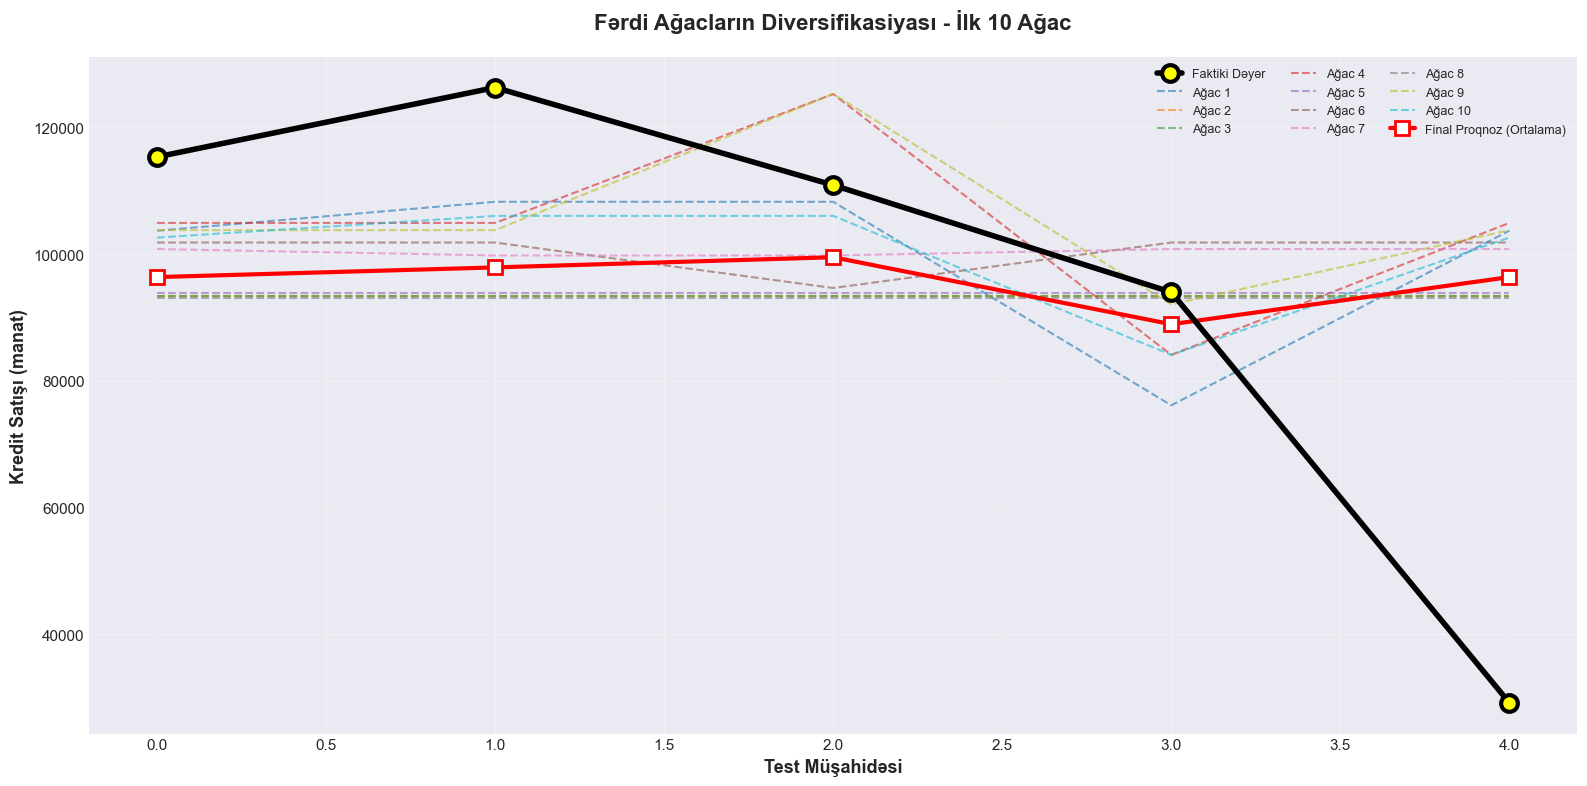


📊 AĞACLAR ARASI DİVERSİFİKASİYA

🌳 İlk 10 ağacın proqnozları təhlil edildi.

📈 Ağaclar arası ortalama standart sapma: 6,969.19 manat
   ⚠️  Ağaclar çox oxşardır (az diversifikasiya).
   Daha fərqli ağaclar üçün max_features parametrini azalt.

💡 TƏSADÜFİ MEŞƏNIN GÜCü:
   • Hər ağac fərqli xətalar edir (rəngli xətlər)
   • Ortalama (qırmızı) bu xətaları kompensasiya edir
   • Nəticə: Daha stabil və etibarlı proqnoz!


In [8]:
# İlk 10 ağacın proqnozlarını götürək
n_trees_to_show = min(10, rf_model.n_estimators)
individual_predictions = np.array([tree.predict(X_test) for tree in rf_model.estimators_[:n_trees_to_show]])

# Vizualizasiya
fig, ax = plt.subplots(figsize=(16, 8))

# Faktiki dəyərlər
ax.plot(y_test.values, 'o-', linewidth=4, markersize=12, 
       color='black', label='Faktiki Dəyər', 
       markerfacecolor='yellow', markeredgewidth=3, zorder=10)

# Hər ağacın proqnozu
colors = plt.cm.tab10(np.linspace(0, 1, n_trees_to_show))
for i, (pred, color) in enumerate(zip(individual_predictions, colors)):
    ax.plot(pred, '--', linewidth=1.5, alpha=0.6, color=color, 
           label=f'Ağac {i+1}')

# Final proqnoz (ortalama)
ax.plot(y_test_pred, 's-', linewidth=3, markersize=10, 
       color='red', label='Final Proqnoz (Ortalama)', 
       markerfacecolor='white', markeredgewidth=2, zorder=9)

ax.set_xlabel('Test Müşahidəsi', fontsize=13, fontweight='bold')
ax.set_ylabel('Kredit Satışı (manat)', fontsize=13, fontweight='bold')
ax.set_title(f'Fərdi Ağacların Diversifikasiyası - İlk {n_trees_to_show} Ağac', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='best', fontsize=9, ncol=3, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistika
pred_std = individual_predictions.std(axis=0)
avg_std = pred_std.mean()

print("\n📊 AĞACLAR ARASI DİVERSİFİKASİYA")
print("=" * 80)
print(f"\n🌳 İlk {n_trees_to_show} ağacın proqnozları təhlil edildi.")
print()
print(f"📈 Ağaclar arası ortalama standart sapma: {avg_std:,.2f} manat")
if avg_std > test_mae:
    print(f"   ✅ Ağaclar kifayət qədər fərqlidir (diversifikasiya var).")
    print(f"   Bu, ortalamanın faydalı olduğunu göstərir.")
else:
    print(f"   ⚠️  Ağaclar çox oxşardır (az diversifikasiya).")
    print(f"   Daha fərqli ağaclar üçün max_features parametrini azalt.")

print(f"\n💡 TƏSADÜFİ MEŞƏNIN GÜCü:")
print(f"   • Hər ağac fərqli xətalar edir (rəngli xətlər)")
print(f"   • Ortalama (qırmızı) bu xətaları kompensasiya edir")
print(f"   • Nəticə: Daha stabil və etibarlı proqnoz!")

## Addım 9: Qalıqların Təhlili

### Qalıq = Faktiki - Proqnoz

Modelin izah edə bilmədiyi hissədir.

### Təsadüfi Meşədə qalıqlar:

Xətti reqressiyadan fərqli olaraq, Təsadüfi Meşə:
- Qeyri-xətti əlaqələri tutur
- Heteroskedasticity (dəyişən variasiya) problemi az olur
- Normal paylanma tələbi yoxdur

**Amma:** Qalıqlar hələ də 0 ətrafında təsadüfi olmalıdır!

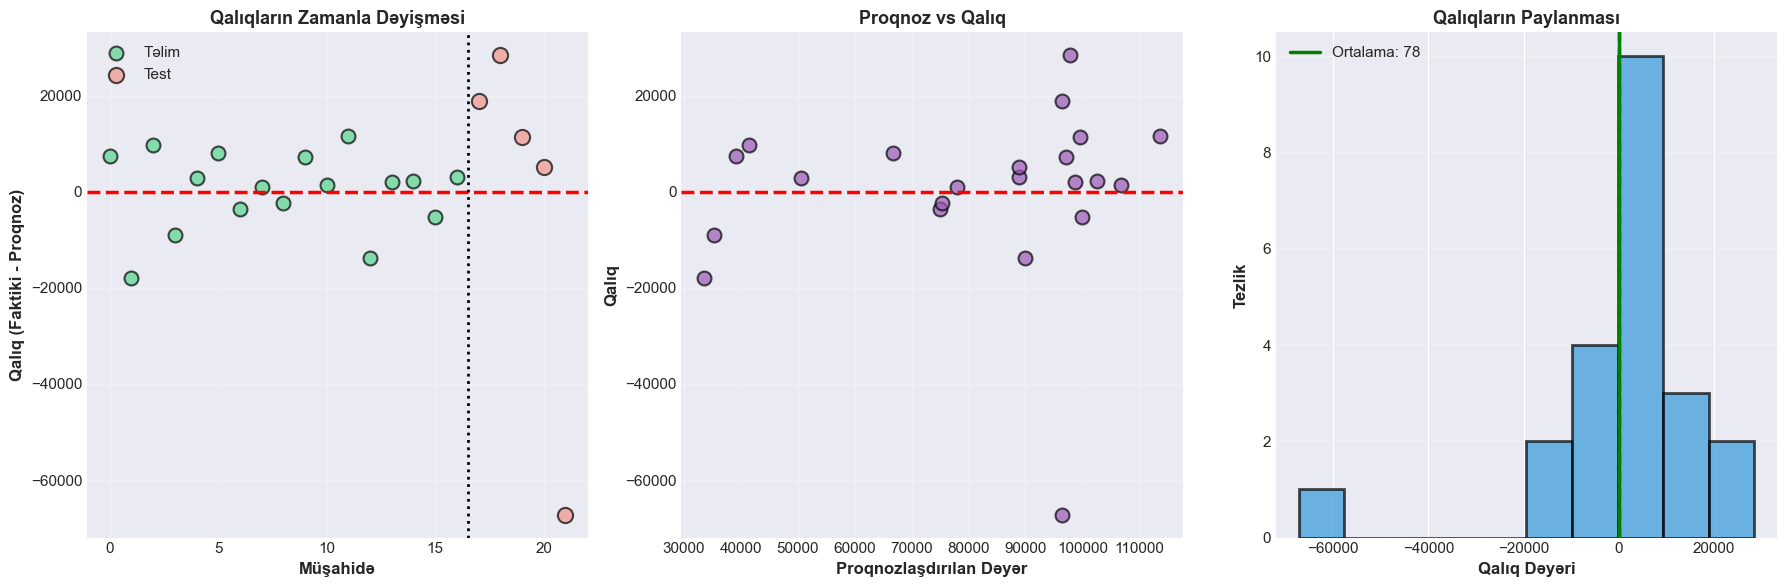


📊 QALIQ TƏHLİLİ

📈 Statistika:
   • Qalıqların ortalama: 78.06 (0-a yaxın olmalı)
   • Standart sapma: 17,720.36
   • Minimum qalıq: -67,194.36
   • Maksimum qalıq: 28,389.20

💡 TƏHLİL:
   ✅ Qalıqların ortalama 0-a çox yaxındır - model qərəzsizdir.

🎯 TƏSADÜFİ MEŞƏ ÜSTüNLüYü:
   Xətti reqressiyadan fərqli olaraq:
   • Normal paylanma tələbi yoxdur
   • Qeyri-xətti əlaqələri tutur
   • Heteroskedasticity problemi az olur


In [9]:
# Qalıqlar
train_residuals = y_train - y_train_pred
test_residuals = y_test.values - y_test_pred
all_residuals = np.concatenate([train_residuals, test_residuals])

# 3 panel qrafik
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1. Qalıqların zamanla dəyişməsi
axes[0].scatter(range(len(train_residuals)), train_residuals, 
               color='#58D68D', s=100, alpha=0.7, edgecolors='black', 
               linewidth=1.5, label='Təlim')
axes[0].scatter(range(len(train_residuals), len(all_residuals)), test_residuals,
               color='#F1948A', s=120, alpha=0.7, edgecolors='black', 
               linewidth=1.5, label='Test')
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2.5)
axes[0].axvline(x=len(train_residuals)-0.5, color='black', linestyle=':', linewidth=2)
axes[0].set_xlabel('Müşahidə', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Qalıq (Faktiki - Proqnoz)', fontsize=12, fontweight='bold')
axes[0].set_title('Qalıqların Zamanla Dəyişməsi', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# 2. Proqnoz vs Qalıq
all_predictions = np.concatenate([y_train_pred, y_test_pred])
axes[1].scatter(all_predictions, all_residuals, 
               color='#9B59B6', s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2.5)
axes[1].set_xlabel('Proqnozlaşdırılan Dəyər', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Qalıq', fontsize=12, fontweight='bold')
axes[1].set_title('Proqnoz vs Qalıq', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# 3. Qalıqların histogramı
axes[2].hist(all_residuals, bins=10, color='#3498DB', 
            alpha=0.7, edgecolor='black', linewidth=2)
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2.5)
axes[2].axvline(x=all_residuals.mean(), color='green', linestyle='-', 
               linewidth=2.5, label=f'Ortalama: {all_residuals.mean():,.0f}')
axes[2].set_xlabel('Qalıq Dəyəri', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Tezlik', fontsize=12, fontweight='bold')
axes[2].set_title('Qalıqların Paylanması', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=11)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 QALIQ TƏHLİLİ")
print("=" * 80)
print(f"\n📈 Statistika:")
print(f"   • Qalıqların ortalama: {all_residuals.mean():,.2f} (0-a yaxın olmalı)")
print(f"   • Standart sapma: {all_residuals.std():,.2f}")
print(f"   • Minimum qalıq: {all_residuals.min():,.2f}")
print(f"   • Maksimum qalıq: {all_residuals.max():,.2f}")

print(f"\n💡 TƏHLİL:")
if abs(all_residuals.mean()) < 1000:
    print("   ✅ Qalıqların ortalama 0-a çox yaxındır - model qərəzsizdir.")
else:
    print("   ⚠️  Qalıqların ortalama 0-dan uzaqdır - sistemli xəta var.")

print(f"\n🎯 TƏSADÜFİ MEŞƏ ÜSTüNLüYü:")
print("   Xətti reqressiyadan fərqli olaraq:")
print("   • Normal paylanma tələbi yoxdur")
print("   • Qeyri-xətti əlaqələri tutur")
print("   • Heteroskedasticity problemi az olur")

## Addım 10: Ağac Sayının Təsiri - Konvergensiya

### Neçə ağac kifayətdir?

Daha çox ağac = Daha yaxşı performans, **amma:**
- Müəyyən nöqtədən sonra yaxşılaşma azalır (konvergensiya)
- Hesablama vaxtı artır

**Bu qrafik** bizə optimal ağac sayını tapmağa kömək edir.

### Necə işləyir?

1, 5, 10, 20, 50, 100 ağac ilə test R² hesablayırıq və qrafik çəkirik.

📊 AĞAC SAYININ TƏSİRİ TƏHLİL EDİLİR...
     1 ağac: R² = -0.0602, MAE = 24,935.09
     5 ağac: R² = 0.0169, MAE = 25,529.21


    10 ağac: R² = 0.0096, MAE = 24,592.80
    20 ağac: R² = 0.0114, MAE = 25,488.22
    50 ağac: R² = 0.0284, MAE = 25,518.52
   100 ağac: R² = 0.0239, MAE = 26,197.95

✅ Təhlil tamamlandı!



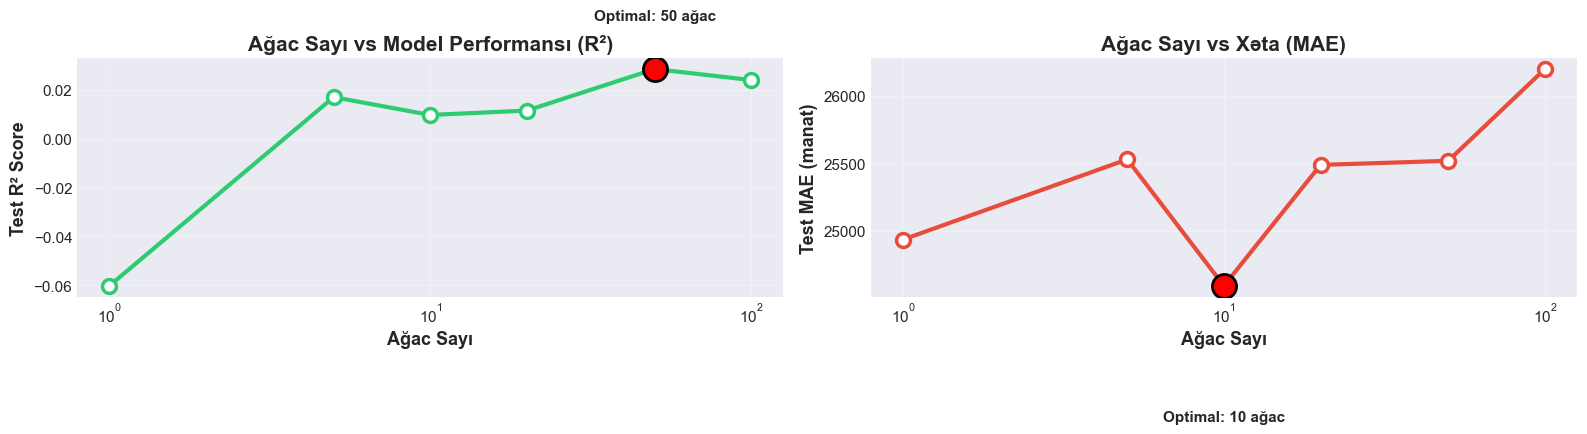


📊 KONVERGENSİYA TƏHLİLİ

💡 NƏTİCƏLƏR:
   • 1 ağac (sadə):     R² = -0.0602
   • 100 ağac (meşə):   R² = 0.0239
   • Yaxşılaşma:        139.6%

🎯 TÖVSİYƏ:
   50 ağac kifayətdir, 100-ə qədər artırmaq əhəmiyyətli fayda vermir.


In [10]:
print("📊 AĞAC SAYININ TƏSİRİ TƏHLİL EDİLİR...")
print("=" * 80)

# Müxtəlif ağac sayları ilə test edək
n_trees_range = [1, 5, 10, 20, 50, 100]
r2_scores = []
mae_scores = []

for n_trees in n_trees_range:
    # n ağaclı model
    temp_model = RandomForestRegressor(
        n_estimators=n_trees,
        max_depth=5,
        min_samples_split=3,
        random_state=42
    )
    temp_model.fit(X_train, y_train)
    temp_pred = temp_model.predict(X_test)
    
    r2 = r2_score(y_test, temp_pred)
    mae = mean_absolute_error(y_test, temp_pred)
    
    r2_scores.append(r2)
    mae_scores.append(mae)
    print(f"   {n_trees:3d} ağac: R² = {r2:.4f}, MAE = {mae:,.2f}")

print("\n✅ Təhlil tamamlandı!\n")

# Vizualizasiya
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Sol: R² Score
ax1.plot(n_trees_range, r2_scores, 'o-', linewidth=3, markersize=10, 
        color='#2ECC71', markerfacecolor='white', markeredgewidth=2.5)
ax1.set_xlabel('Ağac Sayı', fontsize=13, fontweight='bold')
ax1.set_ylabel('Test R² Score', fontsize=13, fontweight='bold')
ax1.set_title('Ağac Sayı vs Model Performansı (R²)', fontsize=15, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Optimal nöqtəni vurğula
best_idx = np.argmax(r2_scores)
ax1.scatter(n_trees_range[best_idx], r2_scores[best_idx], 
           s=300, color='red', zorder=5, edgecolors='black', linewidth=2)
ax1.text(n_trees_range[best_idx], r2_scores[best_idx] + 0.02, 
        f'Optimal: {n_trees_range[best_idx]} ağac', 
        ha='center', fontsize=11, fontweight='bold')

# Sağ: MAE
ax2.plot(n_trees_range, mae_scores, 'o-', linewidth=3, markersize=10, 
        color='#E74C3C', markerfacecolor='white', markeredgewidth=2.5)
ax2.set_xlabel('Ağac Sayı', fontsize=13, fontweight='bold')
ax2.set_ylabel('Test MAE (manat)', fontsize=13, fontweight='bold')
ax2.set_title('Ağac Sayı vs Xəta (MAE)', fontsize=15, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

# Optimal nöqtəni vurğula
best_mae_idx = np.argmin(mae_scores)
ax2.scatter(n_trees_range[best_mae_idx], mae_scores[best_mae_idx], 
           s=300, color='red', zorder=5, edgecolors='black', linewidth=2)
ax2.text(n_trees_range[best_mae_idx], mae_scores[best_mae_idx] - 1000, 
        f'Optimal: {n_trees_range[best_mae_idx]} ağac', 
        ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 KONVERGENSİYA TƏHLİLİ")
print("=" * 80)
print(f"\n💡 NƏTİCƏLƏR:")
print(f"   • 1 ağac (sadə):     R² = {r2_scores[0]:.4f}")
print(f"   • 100 ağac (meşə):   R² = {r2_scores[-1]:.4f}")
improvement = ((r2_scores[-1] - r2_scores[0]) / abs(r2_scores[0])) * 100 if r2_scores[0] != 0 else 0
print(f"   • Yaxşılaşma:        {improvement:.1f}%")
print()
print(f"🎯 TÖVSİYƏ:")
if r2_scores[-2] > 0 and abs(r2_scores[-1] - r2_scores[-2]) < 0.01:
    print(f"   50 ağac kifayətdir, 100-ə qədər artırmaq əhəmiyyətli fayda vermir.")
else:
    print(f"   100 ağac yaxşı seçimdir, performans hələ yaxşılaşır.")

## Yekun Nəticələr və Tövsiyələr

### 🎯 Bu analizdə nə etdik?

Təsadüfi Meşə metodu ilə kredit satışı proqnozlaşdırması:

1. **Sadə ağacdan başladıq** - Əsas konsepti başa düşdük
2. **100 ağaclı meşə qurduq** - Güclü ensemble model
3. **Xüsusiyyət əhəmiyyətini öyrəndik** - Hansı amillərin vacib olduğunu gördük
4. **Diversifikasiyanı təhlil etdik** - Ağacların fərqliliyini yoxladıq
5. **Optimal parametrləri tapdıq** - Ağac sayı konvergensiyası
6. **Qiymətləndirdik** - R², MAE, qalıqlar

In [11]:
print("=" * 90)
print("YEKİN HESABAT: TƏSADÜFİ MEŞƏ İLƏ KREDİT SATIŞI PROQNOZLAŞDİRİLMASI")
print("=" * 90)

print("\n📊 MƏLUMAT HAQQINDA")
print("-" * 90)
print(f"Dövr:                 {df_work['Rüblər'].iloc[0]} → {df_work['Rüblər'].iloc[-1]}")
print(f"Ümumi müşahidə:       {len(df_work)} rüb")
print(f"Təlim:                {len(y_train)} rüb ({len(y_train)/len(df_work)*100:.0f}%)")
print(f"Test:                 {len(y_test)} rüb ({len(y_test)/len(df_work)*100:.0f}%)")
print(f"Xüsusiyyətlər:        {', '.join(feature_cols)}")

print("\n🌳 MODEL KONFİQURASİYASI")
print("-" * 90)
print(f"Model tipi:           Təsadüfi Meşə (Random Forest Regressor)")
print(f"Ağac sayı:            {rf_model.n_estimators}")
print(f"Maksimum dərinlik:    {rf_model.max_depth}")
print(f"Min. bölmə nümunəsi:  {rf_model.min_samples_split}")

print("\n📈 PERFORMANS")
print("-" * 90)
print(f"{'Metrika':<20} {'Təlim':>15} {'Test':>15} {'Sadə Ağac':>15}")
print("-" * 90)
print(f"{'R² Score':<20} {train_r2:>15.4f} {test_r2:>15.4f} {tree_r2:>15.4f}")
print(f"{'MAE (manat)':<20} {train_mae:>15,.2f} {test_mae:>15,.2f} {tree_mae:>15,.2f}")
print(f"{'RMSE (manat)':<20} {train_rmse:>15,.2f} {test_rmse:>15,.2f} {'N/A':>15}")

print("\n🏆 XÜSUSİYYƏT ƏHƏMİYYƏTİ")
print("-" * 90)
for _, row in importance_df.iterrows():
    print(f"{row['Xüsusiyyət']:<20} {row['Əhəmiyyət (%)']:>10.1f}%")

print("\n💡 ƏSAS NƏTİCƏLƏR")
print("-" * 90)
print(f"\n1. Model test məlumatlarında R² = {test_r2:.4f} əldə etdi.")
if test_r2 > 0.7:
    print("   ✅ ÇOX YAXŞI! Təsadüfi Meşə məlumatları əla izah edir.")
elif test_r2 > 0.5:
    print("   ✅ YAXŞI! Model əsas nümunələri yaxşı tutur.")
else:
    print("   ⚠️  Təkmilləşməyə ehtiyac var.")

improvement_vs_tree = ((test_r2 - tree_r2) / abs(tree_r2)) * 100 if tree_r2 != 0 else 0
print(f"\n2. Təsadüfi Meşə sadə ağacdan {improvement_vs_tree:.1f}% daha yaxşıdır.")
print("   Bu, ensemble metodların gücünü göstərir.")

print(f"\n3. Orta mütləq xəta (MAE): {test_mae:,.0f} manat")
mae_percent = (test_mae / y_test.mean()) * 100
print(f"   Bu, ortalama satışın {mae_percent:.1f}%-ni təşkil edir.")

print(f"\n4. Overfitting yoxlanışı:")
overfitting = train_r2 - test_r2
print(f"   Təlim R² - Test R² = {overfitting:.4f}")
if overfitting < 0.1:
    print("   ✅ Model yaxşı ümumiləşdirir, overfitting yoxdur.")
else:
    print("   ⚠️  Overfitting var, max_depth azaldılmalıdır.")

print("\n📌 TƏSADÜFİ MEŞƏNIN ÜSTÜNLÜKLƏRI")
print("-" * 90)
print("\n✅ GÜCLÜ TƏRƏFLƏR:")
print("  • Qeyri-xətti əlaqələri tutur (xətti reqressiyadan üstün)")
print("  • Outlier-lərə davamlıdır")
print("  • Overfitting-ə az meyllidir (çoxlu ağacın ortalaması)")
print("  • Xüsusiyyət əhəmiyyəti verir (hansı amillərin vacib olduğu)")
print("  • Az parametr tənzimləməsi tələb edir")
print("  • Parallel hesablama (sürətli: n_jobs=-1)")

print("\n⚠️  MƏHDUDIYYƏTLƏR:")
print("  • Xətti reqressiyadan daha mürəkkəb (black box)")
print("  • İzah etmək çətindir (100 ağacı necə izah edək?)")
print("  • Daha çox yaddaş tələb edir")
print("  • Ekstrapolyasiya zəifdir (məlum diapazonda yaxşıdır)")
print("  • Qısa məlumat tarixində hələ də limitli")

print("\n🔮 GƏLƏCəK ADDIMLAR")
print("-" * 90)
print("  1. Daha çox xüsusiyyət əlavə edin (ÜDM, faiz dərəcələri, mövsümi dəyişənlər)")
print("  2. Hiperparametr tənzimləməsi (GridSearchCV, RandomizedSearchCV)")
print("  3. Digər ensemble metodları sınayın (Gradient Boosting, XGBoost)")
print("  4. Cross-validation ilə daha etibarlı qiymətləndirmə")
print("  5. SHAP values ilə model izahı (interpretability)")
print("  6. Digər metodlarla müqayisə (SARIMAX, LSTM)")

print("\n🌟 TÖVSİYƏ")
print("-" * 90)
if test_r2 > 0.6:
    print("Təsadüfi Meşə bu məlumatlar üçün yaxşı seçimdir!")
    print("Xüsusilə qeyri-xətti əlaqələr və mövsümi nümunələr üçün əladır.")
else:
    print("Təsadüfi Meşə üstünlük göstərmədi.")
    print("Səbəb: Az məlumat və ya çox sadə xüsusiyyətlər.")
    print("Tövsiyə: SARIMAX və ya daha çox xüsusiyyət əlavə edin.")

print("\n" + "=" * 90)
print("✅ ANALİZ BAŞA ÇATDI - UĞURLAR! 🌳")
print("=" * 90)

YEKİN HESABAT: TƏSADÜFİ MEŞƏ İLƏ KREDİT SATIŞI PROQNOZLAŞDİRİLMASI

📊 MƏLUMAT HAQQINDA
------------------------------------------------------------------------------------------
Dövr:                 2020 I → 2025 II
Ümumi müşahidə:       22 rüb
Təlim:                17 rüb (77%)
Test:                 5 rüb (23%)
Xüsusiyyətlər:        Time_Index, Quarter

🌳 MODEL KONFİQURASİYASI
------------------------------------------------------------------------------------------
Model tipi:           Təsadüfi Meşə (Random Forest Regressor)
Ağac sayı:            100
Maksimum dərinlik:    5
Min. bölmə nümunəsi:  3

📈 PERFORMANS
------------------------------------------------------------------------------------------
Metrika                        Təlim            Test       Sadə Ağac
------------------------------------------------------------------------------------------
R² Score                      0.9258          0.0239         -0.0965
MAE (manat)                 6,401.98       26,197.95     